# Basic EDA for measures

For this dataset, we are going to perform a really basic data analysis just to observe how sensors read vary accross time.

First of all we load all the CSV files for each sensor.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = Path('../../data/processed/measures')

df_dht_11 = pd.read_csv(DATA_PATH / 'DHT11.csv', index_col='time')
df_dht_22 = pd.read_csv(DATA_PATH / 'DHT22.csv', index_col='time')
df_dm = pd.read_csv(DATA_PATH / 'DM280.csv', index_col='time')
df_htu = pd.read_csv(DATA_PATH / 'HTU21.csv', index_col='time')
df_bmp = pd.read_csv(DATA_PATH / 'BMP280.csv', index_col='time')

For simplicity, we are going to use only 2 sensors which cover the three different measures (humidity, temperature and pressure).

Therefore, in this notebook we are going to use `DHT11` and `BMP280` sensors.

## Sensors Hardware

As expected, in our dataset we don't have access to extra information of the sensors. Therefore, it can be a good idea to look for external information about the two sensors that we are analysing \[1, 2\].

The two sensors look like as follows:

![DHT11](img/dht.jpg)

*DHT11 Sensor*

![BMP280](img/bmp.jpg)

*BMP280 Sensor*


`DHT11` sensor provides reads of temperature and humidity while `BMP280` provides reads of atmospheric pressure and temperature. We can see all this values in our data.

In [3]:
print('DHT reads:', df_dht_11.columns)
print('BMP280 reads:', df_bmp.columns)

DHT reads: Index(['humidity', 'temperature', 'sensor'], dtype='object')
BMP280 reads: Index(['pressure', 'temperature', 'sensor'], dtype='object')


## Time Series Analysis

Since, our data is a set of registers along time, it can be seen as a time series, one for each sensor and each measure type. In addition, since our sensors has two different measures we can say that the reads of each sensor is a multivariate timeseries.

To address some characteristics of the time series, is important to know in which time were the measures taken, and how long had the sensors been active.

Before starting with this analysis, we make sure that the `pd.DataFrame`s are sorted by time.

In [4]:
df_dht_11.index = pd.to_datetime(df_dht_11.index)
df_bmp.index = pd.to_datetime(df_bmp.index)

In [5]:
df_dht_11.sort_index(inplace=True)
df_bmp.sort_index(inplace=True)

df_dht_11.head()

,humidity,temperature,sensor
time,,,
2017-12-22 11:22:11+00:00,31.0,27.0,DHT11
2017-12-22 11:22:16+00:00,31.0,28.0,DHT11
2017-12-22 11:22:20+00:00,31.0,28.0,DHT11
2017-12-22 11:22:24+00:00,31.0,28.0,DHT11
2017-12-22 11:22:28+00:00,31.0,28.0,DHT11


Now, we are going to compute the sample rate of the sensor, in other words, we are going to retrieve which is the time interval used to get the data from the sensor.

DHT Sample Rate: 4
BMP Sample Rate: 4


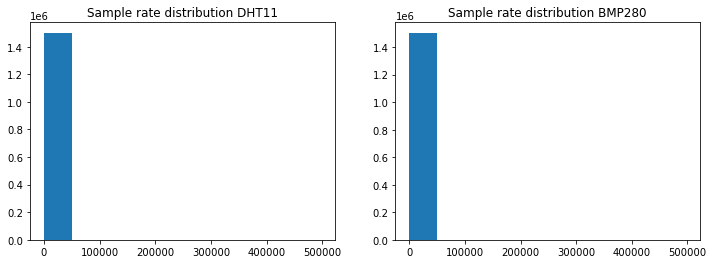

In [6]:
dht_sample_rate = np.diff(df_dht_11.index.values).astype('timedelta64[s]').astype('int32')
bmp_sample_rate = np.diff(df_bmp.index.values).astype('timedelta64[s]').astype('int32')

print('DHT Sample Rate:', np.bincount(dht_sample_rate).argmax())
print('BMP Sample Rate:', np.bincount(bmp_sample_rate).argmax())

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.title('Sample rate distribution DHT11')
plt.hist(dht_sample_rate)

plt.subplot(122)
plt.title('Sample rate distribution BMP280')
plt.hist(bmp_sample_rate)

plt.show();

We can see that in both cases the most frequent sample rate is 4 seconds. But we can also observe high intervals between reads (around 500k), this can mean that the sensors had been off during some hours or, even, days.

In [7]:
print('Highest time without DHT11 reads:', np.max(dht_sample_rate), 'seconds')

Highest time without DHT11 reads: 497466 seconds


To know how many days had the sensors been collecting data, we can simply subtract the intial and final time. This will include *dead* times when sensors were stopped, but we care about the start and end date of data collection. 

In [8]:
def strfdelta(tdelta, fmt):
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

def get_duration(timestamps):
    delta = timestamps[-1] - timestamps[0]
    return strfdelta(delta, "{days} days, {hours} hours and {minutes} minutes")

print('DHT data collection duration is', get_duration(df_dht_11.index))
print('BMP data collection duration is', get_duration(df_bmp.index))

DHT data collection duration is 81 days, 0 hours and 19 minutes
BMP data collection duration is 81 days, 0 hours and 49 minutes


Finally, to get a better idea on how the data looks like, we plot the two metrics of both sensors.

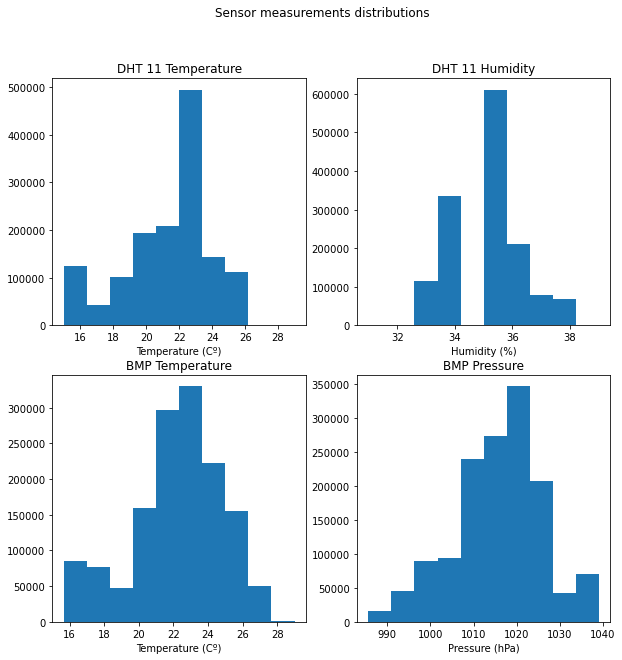

In [9]:

plt.figure(figsize=(10, 10))
plt.suptitle('Sensor measurements distributions')

plt.subplot(221)
plt.title('DHT 11 Temperature')
plt.hist(df_dht_11[df_dht_11.temperature != 0].temperature)
plt.xlabel('Temperature (Cº)')

plt.subplot(222)
plt.title('DHT 11 Humidity')
plt.hist(df_dht_11[df_dht_11.humidity != 0].humidity)
plt.xlabel('Humidity (%)')


plt.subplot(223)
plt.title('BMP Temperature')
plt.hist(df_bmp[df_bmp.temperature != 0].temperature)
plt.xlabel('Temperature (Cº)')

plt.subplot(224)
plt.title('BMP Pressure')
plt.hist(df_bmp[df_bmp.pressure != 0].pressure)
plt.xlabel('Pressure (hPa)')
plt.show()

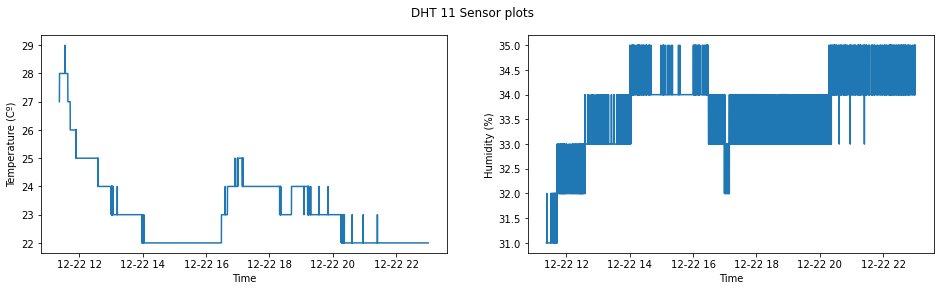

In [10]:
plot_df = df_dht_11.iloc[:10000]

plt.figure(figsize=(16, 4))
plt.suptitle('DHT 11 Sensor plots')

plt.subplot(121)
mask = plot_df.temperature != 0
plt.plot(plot_df[plot_df.temperature != 0].index, plot_df[mask].temperature)
plt.xlabel('Time')
plt.ylabel('Temperature (Cº)')


plt.subplot(122)
mask = plot_df.humidity != 0
plt.plot(plot_df[mask].index, plot_df[mask].humidity)
plt.xlabel('Time')
plt.ylabel('Humidity (%)');

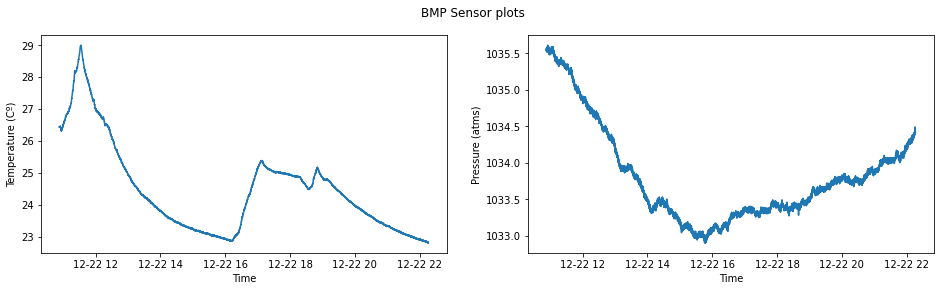

In [11]:
plot_df = df_bmp.iloc[:10000]

plt.figure(figsize=(16, 4))
plt.suptitle('BMP Sensor plots')

plt.subplot(121)
mask = plot_df.temperature != 0
plt.plot(plot_df.index[mask], plot_df.temperature[mask])
plt.xlabel('Time')
plt.ylabel('Temperature (Cº)')

plt.subplot(122)
mask = plot_df.pressure != 0
plt.plot(plot_df[mask].index, plot_df[mask].pressure)
plt.xlabel('Time')
plt.ylabel('Pressure (atms)');

As expected, since is stated in the sensors' datasheets, the BMP sensor is much more precise when reading the temperature. By more precise, we mean that BMP can read more than integer values.

## References

\[1\] [DHT11 Documentation](https://www.mouser.com/datasheet/2/758/DHT11-Technical-Data-Sheet-Translated-Version-1143054.pdf)

\[2\] [BMP280 Documentation](http://descargas.cetronic.es/BOSCHBMP280.pdf)
